In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models

import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math


import os 
import time
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
torch.cuda.is_available()
device = torch.device("cuda")

In [3]:
train = datasets.MNIST("", train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))

In [4]:
test = train = datasets.MNIST("", train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))

In [5]:
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

def batchOfNoise(batch_size):
    q = torch.rand(batch_size, 1, 100)
    return q
    


In [6]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__() 
        self.fc1 = nn.Linear((28*28), 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc4(x)
                         
        return torch.sigmoid(x)
    
    
    
            
dsk = D().to(device)
print(dsk)
optimizerD = optim.Adam(dsk.parameters(), lr=0.0002)


D(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [7]:
class G(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.2)
        x = self.fc4(x)
                         
        return torch.tanh(x)
    
    
    
            
gen = G().to(device)
print(gen)
optimizerG = optim.Adam(gen.parameters(), lr=0.0002)



G(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)


In [8]:
loss_fn = nn.BCELoss()

In [9]:
EPOCHS = 20
for epoch in tqdm(range(EPOCHS)):
    print(epoch)
    for _, data in enumerate(trainset):
        
        
        batchOfData, _ = data 
        batchOfData = batchOfData.view(-1, 1, 28*28).to(device)
        
        dsk.zero_grad()
        dskOnReal = dsk(batchOfData)
        lossD_real = loss_fn(dskOnReal, torch.ones(100,1,1).to(device))
        lossD_real.backward()
        
        
        batchOfFake = gen(batchOfNoise(100).to(device))
        dskOnFake = dsk(batchOfFake.detach())
        #https://github.com/pytorch/examples/issues/116
        lossD_fake = loss_fn(dskOnFake, torch.zeros(100,1,1).to(device))
        lossD_fake.backward()
        
        #lossD = loss_fn(dskOnReal, torch.ones(100,1,1).to(device))) + loss_fn(dskOnFake, torch.zeros(100,1,1).to(device))
        
        optimizerD.step()
        
        
        gen.zero_grad()
        dskOnFake = dsk(batchOfFake)
        lossG = loss_fn(dskOnFake, torch.ones(100,1,1).to(device))
        
        lossG.backward()
        optimizerG.step()
        
        #mean over the batch
        print(f"dskOnReal:{dskOnReal.mean().item()}   dskOnFake:{dskOnFake.mean().item()}")
        

0
dskOnReal:0.5134580135345459   dskOnFake:0.514158308506012
dskOnReal:0.5315096378326416   dskOnFake:0.5154661536216736
dskOnReal:0.5506865978240967   dskOnFake:0.5173997282981873
dskOnReal:0.5702847838401794   dskOnFake:0.5205233097076416
dskOnReal:0.5916301012039185   dskOnFake:0.5252416729927063
dskOnReal:0.6161776781082153   dskOnFake:0.5335173010826111
dskOnReal:0.6459236145019531   dskOnFake:0.5441668629646301
dskOnReal:0.6866442561149597   dskOnFake:0.5605287551879883
dskOnReal:0.7206480503082275   dskOnFake:0.5812390446662903
dskOnReal:0.7498382329940796   dskOnFake:0.6050484776496887
dskOnReal:0.7906669974327087   dskOnFake:0.6244375705718994
dskOnReal:0.7959617376327515   dskOnFake:0.6459354758262634
dskOnReal:0.8179339170455933   dskOnFake:0.6584168672561646
dskOnReal:0.817379891872406   dskOnFake:0.6645376682281494
dskOnReal:0.8065565228462219   dskOnFake:0.6627037525177002
dskOnReal:0.8014267683029175   dskOnFake:0.6475557088851929
dskOnReal:0.7862606644630432   dskOnFake

dskOnReal:0.8010390996932983   dskOnFake:0.7404483556747437
dskOnReal:0.8207122087478638   dskOnFake:0.74308180809021
dskOnReal:0.8094657063484192   dskOnFake:0.7397105097770691
dskOnReal:0.7982214689254761   dskOnFake:0.7393567562103271
dskOnReal:0.7922483682632446   dskOnFake:0.742266833782196
dskOnReal:0.7840411067008972   dskOnFake:0.7363259196281433
dskOnReal:0.7684289216995239   dskOnFake:0.724915623664856
dskOnReal:0.7656468152999878   dskOnFake:0.7116615176200867
dskOnReal:0.7464491724967957   dskOnFake:0.6890159249305725
dskOnReal:0.7271469235420227   dskOnFake:0.6709631681442261
dskOnReal:0.713123619556427   dskOnFake:0.6528277397155762
dskOnReal:0.678105890750885   dskOnFake:0.6270720362663269
dskOnReal:0.6621803045272827   dskOnFake:0.5931141376495361
dskOnReal:0.6221746206283569   dskOnFake:0.5640928745269775
dskOnReal:0.5896373391151428   dskOnFake:0.5062296986579895
dskOnReal:0.5667762756347656   dskOnFake:0.4606409966945648
dskOnReal:0.535034716129303   dskOnFake:0.4054

dskOnReal:0.6572977900505066   dskOnFake:0.46329203248023987
dskOnReal:0.6624549031257629   dskOnFake:0.4767753481864929
dskOnReal:0.6685474514961243   dskOnFake:0.48153990507125854
dskOnReal:0.6643337607383728   dskOnFake:0.48843511939048767
dskOnReal:0.672327995300293   dskOnFake:0.4909120202064514
dskOnReal:0.6615930199623108   dskOnFake:0.48877131938934326
dskOnReal:0.6622874140739441   dskOnFake:0.4927652180194855
dskOnReal:0.6655723452568054   dskOnFake:0.48896726965904236
dskOnReal:0.6443383693695068   dskOnFake:0.4804377257823944
dskOnReal:0.6290419101715088   dskOnFake:0.46896234154701233
dskOnReal:0.605322539806366   dskOnFake:0.453145831823349
dskOnReal:0.6113085746765137   dskOnFake:0.444681853055954
dskOnReal:0.5887727737426758   dskOnFake:0.42766889929771423
dskOnReal:0.5841118693351746   dskOnFake:0.42423492670059204
dskOnReal:0.5783640742301941   dskOnFake:0.43771451711654663
dskOnReal:0.5856504440307617   dskOnFake:0.45780104398727417
dskOnReal:0.5842247605323792   dsk

dskOnReal:0.44896426796913147   dskOnFake:0.34402745962142944
dskOnReal:0.4505959153175354   dskOnFake:0.3514498770236969
dskOnReal:0.4595555067062378   dskOnFake:0.3573356568813324
dskOnReal:0.4604669213294983   dskOnFake:0.36534765362739563
dskOnReal:0.46140724420547485   dskOnFake:0.3694113492965698
dskOnReal:0.46877002716064453   dskOnFake:0.3765052855014801
dskOnReal:0.4722953736782074   dskOnFake:0.3850032091140747
dskOnReal:0.47585830092430115   dskOnFake:0.39209213852882385
dskOnReal:0.4819265305995941   dskOnFake:0.4007880985736847
dskOnReal:0.4805983304977417   dskOnFake:0.40950149297714233
dskOnReal:0.48384642601013184   dskOnFake:0.4167981743812561
dskOnReal:0.49555903673171997   dskOnFake:0.4267590343952179
dskOnReal:0.4934135973453522   dskOnFake:0.43573957681655884
dskOnReal:0.5030632019042969   dskOnFake:0.44633322954177856
dskOnReal:0.5038812160491943   dskOnFake:0.4516640901565552
dskOnReal:0.504876434803009   dskOnFake:0.4583345651626587
dskOnReal:0.5086333155632019 

dskOnReal:0.44602683186531067   dskOnFake:0.3633226454257965
dskOnReal:0.42098814249038696   dskOnFake:0.39425650238990784
dskOnReal:0.45145300030708313   dskOnFake:0.3941146433353424
dskOnReal:0.4728769063949585   dskOnFake:0.3892970085144043
dskOnReal:0.508281946182251   dskOnFake:0.37441131472587585
dskOnReal:0.5295075178146362   dskOnFake:0.36746323108673096
dskOnReal:0.580454409122467   dskOnFake:0.37631598114967346
dskOnReal:0.5918359160423279   dskOnFake:0.3718063235282898
dskOnReal:0.6047767996788025   dskOnFake:0.40221014618873596
dskOnReal:0.6000023484230042   dskOnFake:0.41579532623291016
dskOnReal:0.6028859615325928   dskOnFake:0.4600220322608948
dskOnReal:0.5842445492744446   dskOnFake:0.4995940923690796
dskOnReal:0.5646461844444275   dskOnFake:0.5398380756378174
dskOnReal:0.544557511806488   dskOnFake:0.5716572999954224
dskOnReal:0.5354006886482239   dskOnFake:0.5829551219940186
dskOnReal:0.5648391842842102   dskOnFake:0.594631016254425
dskOnReal:0.5617513656616211   dskO

dskOnReal:0.509269654750824   dskOnFake:0.5344514846801758
dskOnReal:0.4707176983356476   dskOnFake:0.6403400897979736
dskOnReal:0.46943992376327515   dskOnFake:0.715850830078125
dskOnReal:0.43419623374938965   dskOnFake:0.7384946346282959
dskOnReal:0.4215969443321228   dskOnFake:0.7314220070838928
dskOnReal:0.40228983759880066   dskOnFake:0.6701341271400452
dskOnReal:0.4260997176170349   dskOnFake:0.5719709992408752
dskOnReal:0.4182223677635193   dskOnFake:0.5247263312339783
dskOnReal:0.44182851910591125   dskOnFake:0.6016390919685364
dskOnReal:0.41687652468681335   dskOnFake:0.2671796381473541
dskOnReal:0.42124441266059875   dskOnFake:0.036009643226861954
dskOnReal:0.47454091906547546   dskOnFake:0.008181074634194374
dskOnReal:0.49586859345436096   dskOnFake:0.003478982951492071
dskOnReal:0.5242419838905334   dskOnFake:0.002361518098041415
dskOnReal:0.5404337644577026   dskOnFake:0.0022671050392091274
dskOnReal:0.5528915524482727   dskOnFake:0.002718506380915642
dskOnReal:0.570130288

dskOnReal:0.37713178992271423   dskOnFake:0.2710696756839752
dskOnReal:0.37548258900642395   dskOnFake:0.29326727986335754
dskOnReal:0.38346540927886963   dskOnFake:0.2739787995815277
dskOnReal:0.41243788599967957   dskOnFake:0.23522916436195374
dskOnReal:0.42991000413894653   dskOnFake:0.19632872939109802
dskOnReal:0.45298704504966736   dskOnFake:0.1647750586271286
dskOnReal:0.43133190274238586   dskOnFake:0.14013932645320892
dskOnReal:0.4480607509613037   dskOnFake:0.12179698795080185
dskOnReal:0.4717998504638672   dskOnFake:0.11995340138673782
dskOnReal:0.4421198070049286   dskOnFake:0.11707259714603424
dskOnReal:0.4407787322998047   dskOnFake:0.11750715970993042
dskOnReal:0.42438262701034546   dskOnFake:0.1129109337925911
dskOnReal:0.4383443295955658   dskOnFake:0.10965940356254578
dskOnReal:0.4361073076725006   dskOnFake:0.11790585517883301
dskOnReal:0.47410860657691956   dskOnFake:0.12960879504680634
dskOnReal:0.4458288550376892   dskOnFake:0.14641402661800385
dskOnReal:0.4451921

dskOnReal:0.8017278909683228   dskOnFake:0.20443721115589142
dskOnReal:0.769994854927063   dskOnFake:0.23187419772148132
dskOnReal:0.6188750863075256   dskOnFake:0.3327851891517639
dskOnReal:0.5824499130249023   dskOnFake:0.208201065659523
dskOnReal:0.45937955379486084   dskOnFake:0.17861859500408173
dskOnReal:0.33378836512565613   dskOnFake:0.17101532220840454
dskOnReal:0.24678291380405426   dskOnFake:0.2103736400604248
dskOnReal:0.23572829365730286   dskOnFake:0.17492468655109406
dskOnReal:0.15838603675365448   dskOnFake:0.03481778874993324
dskOnReal:0.15450328588485718   dskOnFake:0.008830071426928043
dskOnReal:0.2351030707359314   dskOnFake:0.007347833830863237
dskOnReal:0.29421326518058777   dskOnFake:0.004002678208053112
dskOnReal:0.34883227944374084   dskOnFake:0.00673330994322896
dskOnReal:0.41262465715408325   dskOnFake:0.019303854554891586
dskOnReal:0.41672366857528687   dskOnFake:0.054690875113010406
dskOnReal:0.46439865231513977   dskOnFake:0.1525106430053711
dskOnReal:0.50

dskOnReal:0.567571222782135   dskOnFake:0.3849546015262604
dskOnReal:0.5793332457542419   dskOnFake:0.3550596833229065
dskOnReal:0.5587180852890015   dskOnFake:0.3362216055393219
dskOnReal:0.5673909783363342   dskOnFake:0.3112638592720032
dskOnReal:0.5593177080154419   dskOnFake:0.29861214756965637
dskOnReal:0.566689133644104   dskOnFake:0.2715515196323395
dskOnReal:0.5421576499938965   dskOnFake:0.26731202006340027
dskOnReal:0.5508980751037598   dskOnFake:0.25329357385635376
dskOnReal:0.5361019968986511   dskOnFake:0.22195708751678467
dskOnReal:0.5776559114456177   dskOnFake:0.1922687143087387
dskOnReal:0.5243291258811951   dskOnFake:0.17287471890449524
dskOnReal:0.5694067478179932   dskOnFake:0.16172237694263458
dskOnReal:0.546256959438324   dskOnFake:0.16178709268569946
dskOnReal:0.5614593029022217   dskOnFake:0.17210830748081207
dskOnReal:0.5888362526893616   dskOnFake:0.18086500465869904
dskOnReal:0.5772486329078674   dskOnFake:0.18555594980716705
dskOnReal:0.6275532245635986   ds

dskOnReal:0.532982587814331   dskOnFake:0.04488265514373779
dskOnReal:0.5661031007766724   dskOnFake:0.06397499889135361
dskOnReal:0.538490891456604   dskOnFake:0.08864208310842514
dskOnReal:0.5559542775154114   dskOnFake:0.10767512768507004
dskOnReal:0.5690958499908447   dskOnFake:0.15401263535022736
dskOnReal:0.5627796649932861   dskOnFake:0.19162403047084808
dskOnReal:0.5798460841178894   dskOnFake:0.22350360453128815
dskOnReal:0.6371800303459167   dskOnFake:0.25762611627578735
dskOnReal:0.6381276845932007   dskOnFake:0.287295401096344
dskOnReal:0.6387252807617188   dskOnFake:0.31164926290512085
dskOnReal:0.6441588997840881   dskOnFake:0.35891997814178467
dskOnReal:0.6213299036026001   dskOnFake:0.35841694474220276
dskOnReal:0.661791205406189   dskOnFake:0.3806703984737396
dskOnReal:0.6826220750808716   dskOnFake:0.3920513093471527
dskOnReal:0.6504349112510681   dskOnFake:0.3993910849094391
dskOnReal:0.6389488577842712   dskOnFake:0.4169884920120239
dskOnReal:0.6470740437507629   ds

dskOnReal:0.48813188076019287   dskOnFake:0.32967036962509155
dskOnReal:0.4906237721443176   dskOnFake:0.2846300005912781
dskOnReal:0.4721504747867584   dskOnFake:0.28091493248939514
dskOnReal:0.4964619278907776   dskOnFake:0.25701072812080383
dskOnReal:0.5156267881393433   dskOnFake:0.27152255177497864
dskOnReal:0.512176513671875   dskOnFake:0.291049063205719
dskOnReal:0.5134621262550354   dskOnFake:0.2752763032913208
dskOnReal:0.5119194984436035   dskOnFake:0.2952340841293335
dskOnReal:0.515276312828064   dskOnFake:0.32158148288726807
dskOnReal:0.5314154028892517   dskOnFake:0.2942538857460022
dskOnReal:0.5159144997596741   dskOnFake:0.28538018465042114
dskOnReal:0.5166060328483582   dskOnFake:0.3013979196548462
dskOnReal:0.5261123776435852   dskOnFake:0.27103012800216675
dskOnReal:0.5289840698242188   dskOnFake:0.2598344683647156
dskOnReal:0.524784505367279   dskOnFake:0.2506011128425598
dskOnReal:0.5073452591896057   dskOnFake:0.24523189663887024
dskOnReal:0.5106209516525269   dskO

dskOnReal:0.5443314909934998   dskOnFake:0.21380877494812012
dskOnReal:0.5481347441673279   dskOnFake:0.24779197573661804
dskOnReal:0.597554087638855   dskOnFake:0.26423880457878113
dskOnReal:0.5830967426300049   dskOnFake:0.24808387458324432
dskOnReal:0.6341902613639832   dskOnFake:0.25600406527519226
dskOnReal:0.6475569009780884   dskOnFake:0.27863964438438416
dskOnReal:0.6137977242469788   dskOnFake:0.32103368639945984
dskOnReal:0.6499612331390381   dskOnFake:0.3297559320926666
dskOnReal:0.6276934146881104   dskOnFake:0.33165672421455383
dskOnReal:0.6510226130485535   dskOnFake:0.3392861485481262
dskOnReal:0.6154868006706238   dskOnFake:0.34773698449134827
dskOnReal:0.5480255484580994   dskOnFake:0.35460206866264343
dskOnReal:0.5822729468345642   dskOnFake:0.3791212737560272
dskOnReal:0.5508849024772644   dskOnFake:0.41786420345306396
dskOnReal:0.49946489930152893   dskOnFake:0.4131910502910614
dskOnReal:0.47762325406074524   dskOnFake:0.4623293876647949
15
dskOnReal:0.5025213360786

dskOnReal:0.6098166108131409   dskOnFake:0.3623063564300537
dskOnReal:0.6396547555923462   dskOnFake:0.4105294346809387
dskOnReal:0.7160056233406067   dskOnFake:0.45609548687934875
dskOnReal:0.655523419380188   dskOnFake:0.47911256551742554
dskOnReal:0.6684979200363159   dskOnFake:0.48962587118148804
dskOnReal:0.6620871424674988   dskOnFake:0.4528985023498535
dskOnReal:0.6970875263214111   dskOnFake:0.4152430295944214
dskOnReal:0.6929256916046143   dskOnFake:0.3971978724002838
dskOnReal:0.6606085896492004   dskOnFake:0.34948405623435974
dskOnReal:0.6854852437973022   dskOnFake:0.3426184356212616
dskOnReal:0.6403366923332214   dskOnFake:0.30132052302360535
dskOnReal:0.6244932413101196   dskOnFake:0.2937755882740021
dskOnReal:0.6285895109176636   dskOnFake:0.30245962738990784
dskOnReal:0.6335220336914062   dskOnFake:0.3120366930961609
dskOnReal:0.6023653745651245   dskOnFake:0.3111604154109955
dskOnReal:0.5794042348861694   dskOnFake:0.29072365164756775
dskOnReal:0.5412713289260864   dsk

dskOnReal:0.7967164516448975   dskOnFake:0.2579283118247986
dskOnReal:0.7807333469390869   dskOnFake:0.2647857367992401
dskOnReal:0.7711572051048279   dskOnFake:0.2514112889766693
dskOnReal:0.7398736476898193   dskOnFake:0.2839966416358948
dskOnReal:0.7000389099121094   dskOnFake:0.3080149292945862
dskOnReal:0.7390740513801575   dskOnFake:0.33088386058807373
dskOnReal:0.7509863376617432   dskOnFake:0.35322150588035583
dskOnReal:0.7339194416999817   dskOnFake:0.38219863176345825
dskOnReal:0.692999541759491   dskOnFake:0.3908880949020386
dskOnReal:0.7237399220466614   dskOnFake:0.3823785185813904
dskOnReal:0.6118450164794922   dskOnFake:0.345580518245697
dskOnReal:0.5810285806655884   dskOnFake:0.3197835385799408
dskOnReal:0.5276364088058472   dskOnFake:0.28010255098342896
dskOnReal:0.4580288529396057   dskOnFake:0.2344084531068802
dskOnReal:0.52333664894104   dskOnFake:0.20879456400871277
dskOnReal:0.48488855361938477   dskOnFake:0.20049384236335754
dskOnReal:0.5609655380249023   dskOnF

dskOnReal:0.4379407465457916   dskOnFake:0.3744392693042755
dskOnReal:0.4558735191822052   dskOnFake:0.36190953850746155
dskOnReal:0.48195526003837585   dskOnFake:0.35010623931884766
dskOnReal:0.49020829796791077   dskOnFake:0.3213646709918976
dskOnReal:0.5235037207603455   dskOnFake:0.3007661998271942
dskOnReal:0.4981928765773773   dskOnFake:0.2833704650402069
dskOnReal:0.5206236839294434   dskOnFake:0.2656804323196411
dskOnReal:0.522395133972168   dskOnFake:0.2722119390964508
dskOnReal:0.5472248792648315   dskOnFake:0.2454403042793274
dskOnReal:0.5276671648025513   dskOnFake:0.2521541714668274
dskOnReal:0.5592944025993347   dskOnFake:0.24286913871765137
19
dskOnReal:0.5574170351028442   dskOnFake:0.262593150138855
dskOnReal:0.5787079334259033   dskOnFake:0.26273542642593384
dskOnReal:0.5384737849235535   dskOnFake:0.27836665511131287
dskOnReal:0.5485408902168274   dskOnFake:0.30125609040260315
dskOnReal:0.5510667562484741   dskOnFake:0.31765854358673096
dskOnReal:0.5461753010749817  

In [10]:
see = gen(batchOfNoise(1).to(device))


In [11]:
see.shape

torch.Size([1, 1, 784])

In [12]:
see = see.view(28,28)

In [13]:
see.shape

torch.Size([28, 28])

In [14]:
torch.save(gen.state_dict(), ".gen.pth")

In [15]:
torch.save(dsk.state_dict(), ".dsk.pth")

In [16]:
netG = G()

In [17]:
netD = D()

In [18]:
netG = G()
netG.load_state_dict(torch.load(".gen.pth"))
netG.eval()

G(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [19]:
batchOfNoise(1)

tensor([[[0.0656, 0.9379, 0.6580, 0.9439, 0.1817, 0.4730, 0.1474, 0.8348,
          0.5205, 0.8268, 0.3143, 0.9930, 0.8278, 0.9629, 0.1405, 0.6850,
          0.6718, 0.7691, 0.7596, 0.0785, 0.6049, 0.2003, 0.3483, 0.7787,
          0.5985, 0.9142, 0.6414, 0.2093, 0.6932, 0.3509, 0.7368, 0.8183,
          0.6425, 0.3573, 0.3941, 0.3983, 0.0847, 0.2963, 0.5451, 0.2645,
          0.4952, 0.6643, 0.7970, 0.8649, 0.5984, 0.3673, 0.6664, 0.6161,
          0.1820, 0.4042, 0.6041, 0.4018, 0.7443, 0.4420, 0.8673, 0.2084,
          0.5885, 0.2178, 0.4707, 0.8128, 0.2065, 0.8015, 0.3945, 0.9909,
          0.7586, 0.1564, 0.7628, 0.6952, 0.5666, 0.4663, 0.9015, 0.1729,
          0.6046, 0.2313, 0.5402, 0.0294, 0.9619, 0.2414, 0.9142, 0.0725,
          0.1118, 0.8821, 0.4928, 0.6284, 0.7221, 0.8298, 0.2596, 0.0720,
          0.6926, 0.7253, 0.1448, 0.8673, 0.1864, 0.9384, 0.1599, 0.1226,
          0.3072, 0.3260, 0.3847, 0.4897]]])

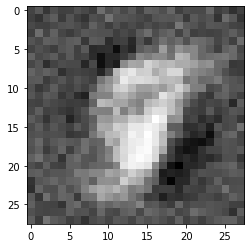

In [20]:
see = netG(batchOfNoise(1))

see.shape

see = see.view(28, 28)

plt.imshow(see.detach().numpy(), cmap = "gray")

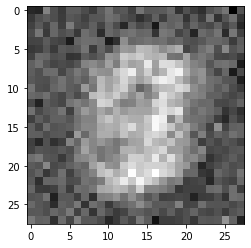

In [21]:
see = netG(torch.zeros(1, 100) + torch.eye(1,100))

see.shape

see = see.view(28, 28)

plt.imshow(see.detach().numpy(), cmap = "gray")

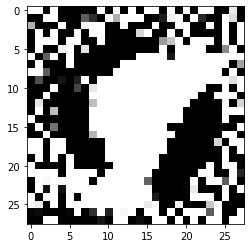

In [22]:
see = netG(torch.ones(1, 100)*100)

see.shape

see = see.view(28, 28)

plt.imshow(see.detach().numpy(), cmap = "gray")

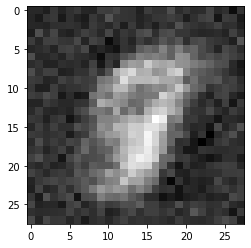

In [23]:
see = netG(batchOfNoise(1)*torch.rand(1))

see.shape

see = see.view(28, 28)

plt.imshow(see.detach().numpy(), cmap = "gray")